In [1]:
import pandas as pd
df = pd.read_csv("../assets/TaiwanAirBox032017.csv").set_index("time")
df

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V507,V508,V509,V510,V511,V512,V513,V514,V515,V516
time,,,,,,,,,,,,,,,,,,,,,
1,8.234563,34.357744,41.250916,41.194228,45.758237,40.424591,36.281097,37.844685,37.835138,44.057510,...,49.152261,55.091967,44.177585,42.569721,34.833622,38.084488,44.854870,46.933081,45.600072,52.152083
2,8.074951,34.455387,39.598679,41.088167,44.970358,39.865248,37.668302,37.439057,37.459381,43.493874,...,48.586604,54.930351,44.329101,41.317196,34.651804,38.463276,45.044264,46.254293,45.387951,51.495833
3,7.918439,34.622896,38.476926,41.116787,44.305423,39.256782,39.073064,37.170659,37.277562,43.126450,...,48.238119,54.718230,44.596777,40.512650,34.616450,38.384003,45.359416,45.830051,45.212193,51.370833
4,7.629787,35.000000,37.800159,41.273497,43.786231,38.687338,38.924916,37.083538,37.134224,42.761130,...,47.738119,54.557624,45.104353,40.027802,34.730447,38.954315,45.789719,45.850253,45.290981,51.386458
5,7.533917,35.494949,37.146960,41.534969,43.316534,38.307347,38.754882,37.050830,37.390285,42.526281,...,47.731806,54.065200,45.814310,39.700529,34.954690,39.820982,46.716991,45.994192,45.903860,51.488542
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
740,47.250000,11.000000,1.500000,4.250000,2.142857,3.000000,3.600000,1.000000,3.571429,1.857143,...,35.125000,43.250000,35.142857,27.250000,20.857143,34.142857,40.800000,32.375000,33.500000,35.000000
741,48.333333,16.333333,2.750000,6.166667,3.500000,4.250000,4.000000,2.500000,5.000000,3.000000,...,40.000000,42.222222,32.571429,19.600000,20.800000,31.500000,38.166667,32.000000,34.500000,37.500000
742,47.666667,18.833333,1.600000,4.857143,2.500000,34.114722,3.750000,2.400000,3.000000,2.400000,...,38.000000,43.000000,32.142857,14.666667,17.666667,19.000000,35.428571,30.333333,34.222222,35.333333


In [2]:
from sklearn.metrics import silhouette_score
from sklearn.cluster import AgglomerativeClustering, KMeans
from sklearn_extra.cluster import KMedoids
import matplotlib.pyplot as plt
import numpy as np

def find_optimal_clusters(data, range_n_clusters, random_state=0, transform=None, distance_matrix_func=None):
    """
    Finds the optimal number of clusters using silhouette scores for KMeans, AgglomerativeClustering, and KMedoids.
    Also returns the labels from the best models.
    
    Parameters:
    - data: DataFrame containing the features for clustering.
    - range_n_clusters: A range of cluster numbers to try.
    - random_state: Integer seed for reproducibility.
    - transform: Optional function to transform data before clustering.
    - distance_matrix_func: Optional function to compute a custom distance matrix.
    
    Returns:
    - Best number of clusters and labels for KMedoids and AgglomerativeClustering.
    """
    silhouette_scores_kmedoids = []
    silhouette_scores_hierarchical = []
    labels_kmedoids_best = None
    labels_hierarchical_best = None

    transformed_data = data.apply(transform) if transform is not None else data
    distance_matrix = distance_matrix_func(transformed_data) if distance_matrix_func is not None else None

    for n_clusters in range_n_clusters:
        # AgglomerativeClustering
        if distance_matrix is not None:
            hierarchical = AgglomerativeClustering(n_clusters=n_clusters, metric='precomputed', linkage='average')
            cluster_labels_hierarchical = hierarchical.fit_predict(distance_matrix)
        else:
            hierarchical = AgglomerativeClustering(n_clusters=n_clusters, linkage='average')
            cluster_labels_hierarchical = hierarchical.fit_predict(transformed_data.T)
        silhouette_avg_hierarchical = silhouette_score(data.T, cluster_labels_hierarchical)
        silhouette_scores_hierarchical.append(silhouette_avg_hierarchical)

        # KMedoids or KMeans
        if distance_matrix is not None:
            kmedoids = KMedoids(n_clusters=n_clusters, metric="precomputed", random_state=random_state).fit(distance_matrix)
        else:
            kmedoids = KMeans(n_clusters=n_clusters, random_state=random_state).fit(transformed_data.T)
        cluster_labels_kmedoids = kmedoids.labels_
        silhouette_avg_kmedoids = silhouette_score(data.T, cluster_labels_kmedoids)
        silhouette_scores_kmedoids.append(silhouette_avg_kmedoids)

    best_index_kmedoids = np.argmax(silhouette_scores_kmedoids)
    best_index_hierarchical = np.argmax(silhouette_scores_hierarchical)
    best_n_clusters_kmedoids = range_n_clusters[best_index_kmedoids]
    best_n_clusters_hierarchical = range_n_clusters[best_index_hierarchical]

    # Refit with best number of clusters to get the labels
    if distance_matrix is not None:
        best_kmedoids_model = KMedoids(n_clusters=best_n_clusters_kmedoids, metric="precomputed", random_state=random_state).fit(distance_matrix)
        labels_kmedoids_best = best_kmedoids_model.labels_
    else:
        best_kmedoids_model = KMeans(n_clusters=best_n_clusters_kmedoids, random_state=random_state).fit(transformed_data.T)
        labels_kmedoids_best = best_kmedoids_model.labels_
    
    if distance_matrix is not None:
        best_hierarchical_model = AgglomerativeClustering(n_clusters=best_n_clusters_hierarchical, metric='precomputed', linkage='average').fit_predict(distance_matrix)
    else:
        best_hierarchical_model = AgglomerativeClustering(n_clusters=best_n_clusters_hierarchical, linkage='average').fit_predict(transformed_data.T)
    
    labels_hierarchical_best = best_hierarchical_model

    # Plotting silhouette scores for each method
    plt.figure(figsize=(12, 6))
    plt.plot(range_n_clusters, silhouette_scores_kmedoids, label='KMedoids Silhouette Score')
    plt.plot(range_n_clusters, silhouette_scores_hierarchical, label='Agglomerative Silhouette Score')
    plt.xlabel('Number of clusters')
    plt.ylabel('Silhouette Score')
    plt.title('Silhouette Scores for Different Number of Clusters')
    plt.legend()
    plt.show()

    print(f"Best number of clusters for KMedoids: {best_n_clusters_kmedoids}")
    print(f"Best number of clusters for Agglomerative: {best_n_clusters_hierarchical}")

    return best_n_clusters_kmedoids, labels_kmedoids_best, best_n_clusters_hierarchical, labels_hierarchical_best

# Example usage:
range_n_clusters = list(range(2, 10))
best_kmedoids, labels_kmedoids, best_hierarchical, labels_hierarchical = find_optimal_clusters(df, range_n_clusters, random_state=42)

/home/maurits/miniconda3/envs/develop/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/maurits/miniconda3/envs/develop/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/maurits/miniconda3/envs/develop/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/maurits/miniconda3/envs/develop/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: Fut

KeyboardInterrupt: 

In [ ]:
from statsmodels.tsa.ar_model import ar_select_order
from statsmodels.tools.sm_exceptions import ValueWarning
import warnings

def get_max_order(df):
    warning_message_pattern = "An unsupported index was provided and will be ignored when e.g. forecasting."

    max_lags = []

    for column in df.columns:
        series_non_missing = df[column].dropna()  # Drop missing values for the current column
        n_obs_non_missing = len(series_non_missing)
        maxlag = min(10, n_obs_non_missing // 10)
        with warnings.catch_warnings():
            warnings.filterwarnings("ignore", category=ValueWarning, message=warning_message_pattern)
            mod = ar_select_order(df[column], maxlag=maxlag, trend='c', ic='bic')
        optimal_lags = len(mod.ar_lags) if mod.ar_lags is not None else 0
        max_lags.append(optimal_lags)

    # Find the maximum number of lags across all columns
    max_order = max(max_lags)
    return max_order

n_lags = get_max_order(df)

print(f"Maximum number of lags across all columns: {n_lags}")


/home/maurits/miniconda3/envs/develop/lib/python3.11/site-packages/statsmodels/tsa/ar_model.py:2129: RuntimeWarning: divide by zero encountered in log
  llf = -nobs * (np.log(2 * np.pi * sigma2) + 1) / 2


Maximum number of lags across all columns: 6


/home/maurits/miniconda3/envs/develop/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/maurits/miniconda3/envs/develop/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/maurits/miniconda3/envs/develop/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/maurits/miniconda3/envs/develop/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: Fut

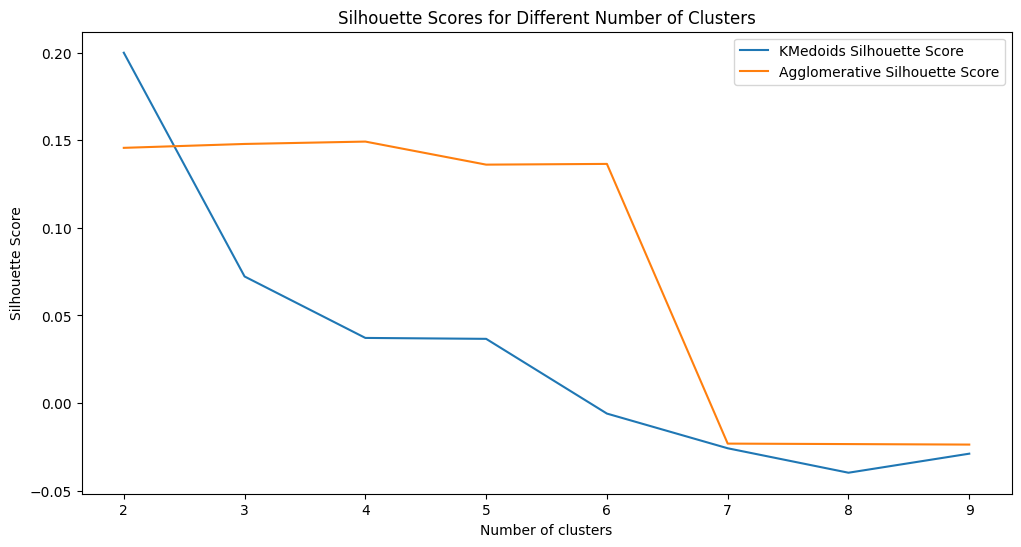

Best number of clusters for KMedoids: 2
Best number of clusters for Agglomerative: 4


In [ ]:
import pandas as pd
from statsmodels.tsa.stattools import acf

def calculate_acf(series, n_lags=5):
    """
    Calculate the Autocorrelation Function (ACF) for a given pandas Series.

    Parameters:
    - series: Pandas Series to calculate ACF for.
    - n_lags: Number of lags to calculate ACF for.

    Returns:
    - A pandas Series of ACF values for lags 1 to n_lags.
    """
    # Ensure series has no missing values and enough data points
    if series.dropna().shape[0] > n_lags: 
        acf_values = acf(series.dropna(), nlags=n_lags, fft=True)[1:] # Exclude lag 0
        return pd.Series(acf_values, index=[f'L{i}' for i in range(1, n_lags+1)])
    else: # Return NaNs if not enough data
        return pd.Series([pd.NA] * n_lags, index=[f'{i}' for i in range(1, n_lags+1)])


acf_df = df.apply(calculate_acf, n_lags=n_lags)

acf_df.head()
best_kmedoids, labels_kmedoids, best_hierarchical, labels_hierarchical = find_optimal_clusters(df, range_n_clusters, random_state=42, 
                                                       transform=lambda data: calculate_acf(data, n_lags=n_lags))

/home/maurits/miniconda3/envs/develop/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/maurits/miniconda3/envs/develop/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/maurits/miniconda3/envs/develop/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/maurits/miniconda3/envs/develop/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: Fut

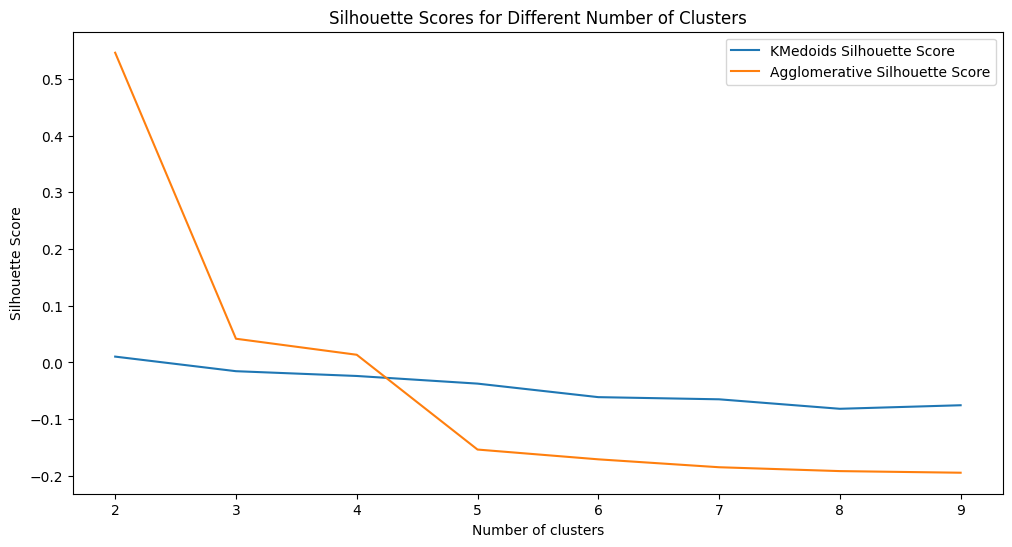

Best number of clusters for KMedoids: 2
Best number of clusters for Agglomerative: 2


In [ ]:
import pandas as pd
from statsmodels.tsa.ar_model import AutoReg

def fit_ar_and_extract_coeffs(series, n_lags=5, trend='c'):
    """
    Fits an AR model to a pandas Series and extracts the AR coefficients.
    
    Parameters:
    - series: Pandas Series to fit the AR model to.
    - n_lags: Number of lags for the AR model.
    - trend: Trend specification for the AR model ('n' for no trend, 'c' for constant).
    
    Returns:
    - A pandas Series of AR coefficients.
    """
    warning_message_pattern = "An unsupported index was provided and will be ignored when e.g. forecasting."

    if series.dropna().shape[0] > n_lags:  # Ensure enough data points
        with warnings.catch_warnings():
            warnings.filterwarnings("ignore", category=ValueWarning, message=warning_message_pattern)
            ar_model = AutoReg(series.dropna(), lags=n_lags, trend=trend)
            ar_model_fitted = ar_model.fit()
        
        # Extract AR coefficients, skipping the intercept if trend is not 'n'
        coeffs = ar_model_fitted.params if trend == 'n' else ar_model_fitted.params[1:]
        coeffs.index = [f'L{i}' for i in range(1, len(coeffs)+1)]
        return coeffs
    else:
        # Return NaNs if not enough data
        return pd.Series([pd.NA] * n_lags, index=[f'L{i}' for i in range(1, n_lags+1)])

ar_coeffs_df = df.apply(fit_ar_and_extract_coeffs, n_lags=n_lags, trend='c')

ar_coeffs_df.head()

best_kmedoids, labels_kmedoids, best_hierarchical, labels_hierarchical = find_optimal_clusters(df, range_n_clusters, random_state=42, 
                                                       transform=lambda data: fit_ar_and_extract_coeffs(data, n_lags=n_lags))


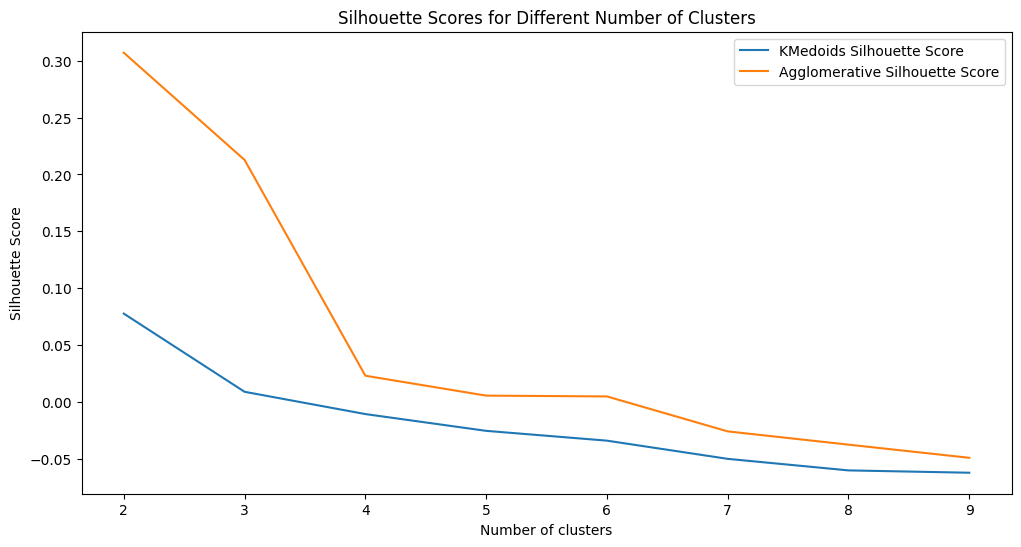

Best number of clusters for KMedoids: 2
Best number of clusters for Agglomerative: 2


In [ ]:
def calculate_r_squared_autocorrelation(series, max_lag):
    # Compute autocorrelation values
    autocorr_values = acf(series, nlags=max_lag, fft=True)
    
    r_squared_values = []
    for i in range(1, max_lag + 1):
        # Construct the autocorrelation matrix up to lag i
        R_X_i = np.array([[autocorr_values[np.abs(j-k)] for k in range(i)] for j in range(i)])
        
        # Invert the autocorrelation matrix
        R_X_i_inv = np.linalg.inv(R_X_i)
        
        # Construct the autocorrelation vector up to lag i
        rho_X_1_i = np.array(autocorr_values[1:i+1]).reshape(-1, 1)
        
        # Calculate r^2 using the given formula
        r_squared = np.dot(np.dot(rho_X_1_i.T, R_X_i_inv), rho_X_1_i).item()
        r_squared_values.append(r_squared)
        
    return r_squared_values

def acf_dissimilarity(df, max_lag):
    r_squared_df = df.apply(lambda x: calculate_r_squared_autocorrelation(x, max_lag))
    
    # Sum of the logarithms for to avoid rounding errors
    log_sum = np.log(1 - r_squared_df).sum()

    # Exponentiate to negate log.
    geometric_mean_exp = np.exp(log_sum / (max_lag + 1)).to_numpy()

    acf_distance = np.abs(geometric_mean_exp[:, np.newaxis] - geometric_mean_exp[np.newaxis, :])
    return acf_distance

best_kmedoids, labels_kmedoids, best_hierarchical, labels_hierarchical = find_optimal_clusters(df, range_n_clusters, random_state=42, transform=None, 
                                                         distance_matrix_func=lambda data: acf_dissimilarity(data, max_lag=n_lags))


In [ ]:
acf_distance = acf_dissimilarity(df, n_lags)
acf_distance

array([[0.        , 0.04183372, 0.06373729, ..., 0.05590676, 0.05149934,
        0.05520917],
       [0.04183372, 0.        , 0.02190356, ..., 0.09774049, 0.09333306,
        0.0970429 ],
       [0.06373729, 0.02190356, 0.        , ..., 0.11964405, 0.11523662,
        0.11894646],
       ...,
       [0.05590676, 0.09774049, 0.11964405, ..., 0.        , 0.00440743,
        0.00069759],
       [0.05149934, 0.09333306, 0.11523662, ..., 0.00440743, 0.        ,
        0.00370984],
       [0.05520917, 0.0970429 , 0.11894646, ..., 0.00069759, 0.00370984,
        0.        ]])

In [ ]:
from statsmodels.tsa.stattools import ccf
from tqdm.notebook import tqdm

def compute_autocorrelation_norms(df, h):
    norms = {}
    for column in df.columns:
        series = df[column].dropna()  # Ensure no NaN values
        ccf_values = ccf(series, series, adjusted=True)
        first = list(reversed(ccf_values[1:h]))
        second = ccf_values[:h]
        autocorr_values = np.concatenate([first, second])
        norms[column] = np.linalg.norm(autocorr_values)
    return norms

def compute_cc_matrix(df, h):
    n = df.shape[1]  # Number of series
    cc_matrix = np.zeros((n, n))
    
    # Precompute autocorrelation norms for each series
    autocorr_norms = compute_autocorrelation_norms(df, h)
    

    for i in tqdm(range(n)):
        for j in range(i+1, n):  # The matrix is symmetric
            series_i = df.iloc[:, i].dropna()
            series_j = df.iloc[:, j].dropna()
            
            # Compute cross-correlation for lags -h to h
            first = list(reversed(ccf(series_j, series_i, adjusted=True)[1:h]))
            second = ccf(series_i, series_j, adjusted=True)[:h]
            cross_correlations = np.concatenate([first, second])
            norm_xy = np.linalg.norm(cross_correlations)
            
            # Use precomputed autocorrelation norms
            norm_xx = autocorr_norms[df.columns[i]]
            norm_yy = autocorr_norms[df.columns[j]]

            # Compute DCC,h dissimilarity
            cc_ij = 1 - (norm_xy**2) / (norm_xx * norm_yy)
            cc_matrix[i, j] = cc_matrix[j, i] = cc_ij
            
    return cc_matrix

best_kmedoids, labels_kmedoids, best_hierarchical, labels_hierarchical = find_optimal_clusters(df, range_n_clusters, random_state=42, transform=None, 
                                                         distance_matrix_func=lambda data: compute_cc_matrix(data, n_lags // 2))


  0%|          | 0/516 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
# Example usage
cc_matrix = compute_cc_matrix(df, n_lags // 2)
cc_matrix

  0%|          | 0/516 [00:00<?, ?it/s]

array([[0.        , 0.98676967, 0.97444837, ..., 0.99988466, 0.99886758,
        0.99852414],
       [0.98676967, 0.        , 0.13115139, ..., 0.99942679, 0.99971149,
        0.99130292],
       [0.97444837, 0.13115139, 0.        , ..., 0.99874803, 0.99469768,
        0.99850934],
       ...,
       [0.99988466, 0.99942679, 0.99874803, ..., 0.        , 0.07556206,
        0.35830547],
       [0.99886758, 0.99971149, 0.99469768, ..., 0.07556206, 0.        ,
        0.29935375],
       [0.99852414, 0.99130292, 0.99850934, ..., 0.35830547, 0.29935375,
        0.        ]])

In [ ]:
import os
os.environ['R_HOME'] = '/usr/lib/R/'

import rpy2
from rpy2.robjects import pandas2ri
from rpy2.robjects.packages import importr
pandas2ri.activate()

base = importr('base')
utils = importr('utils')
SLBDD = importr('SLBDD')

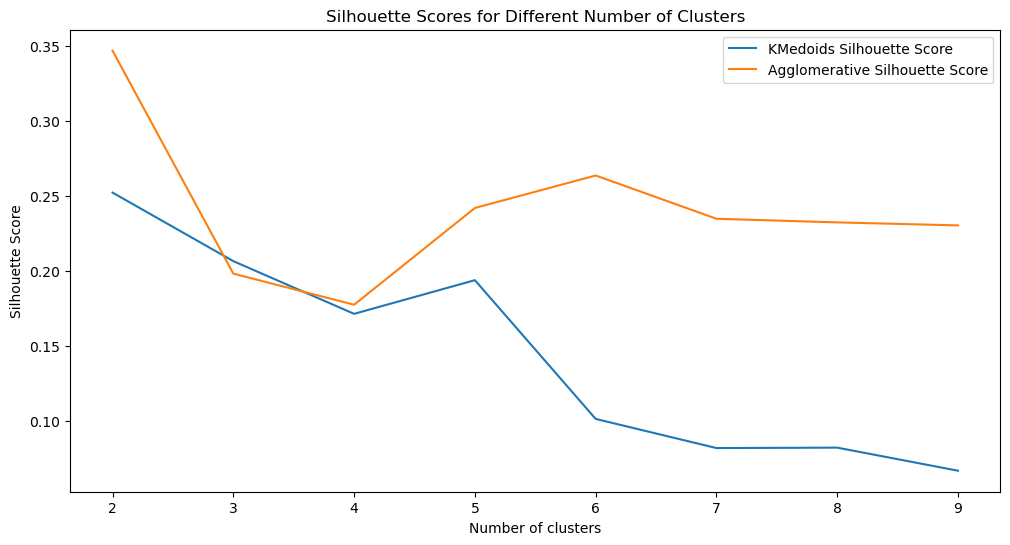

Best number of clusters for KMedoids: 2
Best number of clusters for Agglomerative: 2


In [ ]:
def compute_gcc_matrix(df, n_lags):
    r_df = pandas2ri.py2rpy(df)
    result = SLBDD.GCCmatrix(r_df, n_lags)
    gcc_distance_matrix = result.rx2('DM')
    return gcc_distance_matrix

best_kmedoids, labels_kmedoids, best_hierarchical, labels_hierarchical = find_optimal_clusters(df, range_n_clusters, random_state=42, transform=None, 
                                                         distance_matrix_func=lambda data: compute_gcc_matrix(data, n_lags))


In [ ]:
gcc_distance_matrix = compute_gcc_matrix(df, n_lags)
gcc_distance_matrix

array([[0.        , 0.98790944, 0.98831155, ..., 0.99345315, 0.99431862,
        0.99544578],
       [0.98790944, 0.        , 0.49184932, ..., 0.98887122, 0.98880293,
        0.98610912],
       [0.98831155, 0.49184932, 0.        , ..., 0.98138246, 0.98730847,
        0.99180628],
       ...,
       [0.99345315, 0.98887122, 0.98138246, ..., 0.        , 0.38109674,
        0.76979739],
       [0.99431862, 0.98880293, 0.98730847, ..., 0.38109674, 0.        ,
        0.69421347],
       [0.99544578, 0.98610912, 0.99180628, ..., 0.76979739, 0.69421347,
        0.        ]])